# Dragalia Lost Summoning Strategy Calculator
The purpose of this notebook is to determine the optimal strategy for summoning in the mobile game [Dragalia Lost](https://dragalialost.com/en/). Dragalia Lost allows the user to summon 'units' with which they can play the game. Different units have different rarities, falling into the categories of either 3-stars, 4-stars, or 5-stars, where the rarity increases the more stars the unit has. The intent of this calculator is to find the best strategy for getting the most 5-star units.

## Summoning Rules
The rules of summoning are as follows:
1. There are two types of summons: a single summon and a tenfold summon. A single summon is exactly as it sounds: it summons one unit. A tenfold summon, however, is not only ten summons, but it also guarantees that out of the 10 summons, at least one will be a 4-star unit or higher.
2. A tenfold summon costs 10 times the cost of a single summon.
3. Every 10 summons that go without a 5-star unit appearing causes the chance of a 5-star unit appearing to increase (pity increase). After the completion of a tenfold summon or a single summon, if a 5-star unit was obtained, the pity increase disappears and the chance of a 5-star unit appearing becomes its base rate again.
4. A tenfold summon will only adjust the pity increase after all 10 summons have happened. For an example of where this point is relevant, consider the case where the first summon of the tenfold is a 5-star unit: the remaining 9 summonable units still have the same pity increase (pity increase won't be adjusted until the summon is completed) which could mean better chances, but on the other hand, if none of the remaining summoned units end up being 5-star units, they don't end up counting towards the next pity increase because there was still a 5-star unit in the entire tenfold summon.

## Optimal Strategy Definition
I define an optimal strategy to be the best combination of single and tenfold summons that nets the highest amount of 5-star units given a finite amount of value to spend on summons. There are many conflicting theories about the best strategy to get the most amount of 5-star units for a fixed price: one strategy I found online was to do 10 single summons to raise the pity for a following tenfold, whereas another strategy I found was to do 20 single summons before a tenfold. I will try and explore strategies to determine the best one for getting the most 5-star units with a fixed price.

## Notation
The base rate for summoning 5-star units is actually variable depending on the time of summoning (There is a 4% chance normally, but a 6% chance during 'galas'). As such, I will denote the base rate of summoning as $p$. The pity increase is always in increments of 0.5%, but I will still notate a single pity increase as $q$.<br/>
For an example, supposing I summoned 20 single summons without getting a 5-star unit. The rate at which I would get 5-star units for my next summon would be $p + 2q$ which is the base rate plus 2 pity increases. If I then proceeded to perform either type of summon and get at least one 5-star unit, the rate at which I would get 5-star units would then become $p$ for the next summon because the pity has been broken.

In [1]:
p = 0.06
q = 0.005

## Problem Statement / Assumptions
I will define a strategy as a sequence of single summons and tenfold summons that is repeated until the desired number of summons has been performed. How this works is described in further detail below.<br/>
For the sake of this problem, I will assume that I have enough Wyrmite (currency) to perform 120 summons total (this ends up being 14,400 Wyrmite). I chose 120 because 12 is divisible in many ways and 10 summons is the base unit for the pity increase and for the tenfold summon. The optimal strategy for 120 may scale up and probably still performs well when scaled up, but it isn't guaranteed to be the optimal strategy for larger numbers of summons because there may be other strategies that will not be tested with the assumption of 120 summons.<br/>
Another important assumption is that single summons will only ever be done in groups of 10. I am making this assumption because if single summons are not done in groups of 10, they are not being used optimally for the pity increase. For example, if I were to perform 5 single summons and then a tenfold summon, the single summons have no bearing on the pity increase: either the tenfold netted a 5-star unit and the pity increase is reset, or the tenfold summon gave no 5-star units and the pity rate was raised once. The 5 single summons in that scenario contributed nothing.<br/>
I will also assume that the optimal strategy restarts as soon as a 5-star unit has been obtained. For example, if a strategy is to perform 30 single summons and then a tenfold summon, but a 5-star unit is obtained on the 3rd summon, rather than continuing with 27 single summons and then a tenfold summon, I will assume that it is optimal to restart the strategy from the beginning. My justifications for this assumptions are partially derived from the previous assumption.<br/>
Furthermore, I will assume that the optimal strategy, if it involves single summons, will have the single summons always before tenfold summons. I am assuming this because tenfold summons are ideal with a high pity increase and single summons are optimal for raising pity. It doesn't make sense for a single summon to occur after a tenfold because the higher pity would be wasted with a single summon only being able to give at most 1 5-star unit. Along a similar vein, this means that I will assume the optimal strategy will always involve trying to finish the summon off with tenfold summons until the pity has been broken: it doesn't make sense to restart the strategy to single summons if the previous run-through of the strategy raised the pity and didn't net a 5-star unit.<br/>
Lastly, I will assume that the guaranteed 4-star or above unit in a tenfold summon has no bearing on the probability of getting a 5-star unit. I am unsure of whether this is a fair assumption, but I am unable to find any information on how this guarantee is resolved.

In [2]:
# List of strategies: strategies are encoded as how many sets of 10 single summons to perform before pity-breaking with tenfolds
# eg. the strategy that is encoded as 2 means perform 20 single summons and then do tenfolds until a 5-star unit is obtained
# Strategies go from 0 (entirely tenfolds) to 12 (entirely single summons) because of the assumption of 120 total summons
strategies = range(13)

## Mathematical Description
The tenfold summons can be considered to follow a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) because each of the summons is either a 5-star or not a 5-star and the probabilities for each unit in the tenfold summon are the same and independent of the other summons within the tenfold summon.<br/>
On the other hand, each individual single summon follows a [bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) because the summon is a single trial that results in either a 5-star or not a 5-star. However, due to the assumption that single summons will always be executed in sets of 10 where the pity doesn't change in those 10 single summons, the set of single summons can be instead considered to follow a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution).<br/>
The difficulty of formalizing this scenario mathematically is that grouping summons in groups of 10 makes each group not independent from each other: the results of one group of 10 affect the probabilities of the next group of 10 because of the pity system.<br/>
One way of brute-forcing this problem would be to generate all possible results of 120 summons. Then for each possibility of an outcome, calculate it's probability of ocurring under a strategy (that means run the strategy as if receiving the results of the given outcome, and calculate probabilities for the results as if the results were obtained by chance). In short, one would give each strategy a mapping of possible outcome to it's corresponding probability under that strategy. To then determine which strategy performs the best, find the strategy with the best [expected value](https://en.wikipedia.org/wiki/Expected_value): for each item in a strategy's mapping, multiply the number 5-stars in the outcome with the probability of that outcome, and then sum up the results of the multiplication to get the expected number of 5-star units for that strategy. The optimal strategy would then be the strategy that has the highest expected value for number of 5-star units. This is all fine and dandy except for one issue: generating all possible outcomes of 120 summons would give $2^{120}$ possible outcomes (2 is the base because each of the 120 results in an outcome is either a success with a 5-star unit or a failure with any other unit, which is 2 possibilities for each summon). This is too many outcomes for a computer to handle within a reasonable amount of time. 

In [3]:
2 ** 120

1329227995784915872903807060280344576

## Simulation
Because I am unaware of any other clever ways of attacking this problem, I will instead try to run many simulations and compare which strategies perform the best over simulations. With enough simulations, the data should become accurate in representing reality, but they will never be exact or guaranteed to be correct. This is because RNG (however unlikely) may produce repeated lucky or unlucky results, which, while accurate to reality, doesn't reveal the 'true' values that result from mathematically calculating everything. The repetition of simulations is an attempt to reduce the effect of temporary RNG luck and an attempt to even results out so that they approach towards their 'true' value.

In [4]:
import random

numberTrials = 100_000
numberSummonsPerTrial = 120

"""
Runs one simulation with the given strategy and returns how many 5-stars were obtained total
Strategy follows the format described in a previous cell
"""
def simulate(strategy):
    # Initial conditions for a trial
    numberSummonsRemaining = numberSummonsPerTrial
    numberFiveStars = 0
    numberSetsOfSinglesSinceLastFiveStar = 0
    fiveStarRate = p
    
    # Runs through either tenfolds or sets of single summons as dictated by the given strategy
    # Stops when there are less than 10 summons remaining (cannot perform a tenfold anymore)
    while numberSummonsRemaining >= 10:
        
        # Determine whether the strategy dictates a tenfold or a set of single summons
        shouldPerformSetOfSingles = numberSetsOfSinglesSinceLastFiveStar < strategy
        
        # Run through a set of single summons or a tenfold summon
        results = []
        if shouldPerformSetOfSingles:
            while (len(results) == 0 or not results[-1]) and len(results) < 10:
                results.append(random.random() < fiveStarRate)
            numberSetsOfSinglesSinceLastFiveStar += 1 #if we did get a 5 star in this, this will be set to 0 below
        else:
            results = [random.random() < fiveStarRate for _ in range(10)]
        
        # Adjust all parameters based on summon results
        numberSummonsRemaining -= len(results)
        fiveStarGain = sum(results)
        numberFiveStars += fiveStarGain
        if fiveStarGain > 0:
            fiveStarRate = p
            numberSetsOfSinglesSinceLastFiveStar = 0
        else: #necessarily 10 summons have happened if we got no 5-stars
            fiveStarRate += q
            
    # Finishes the remaining summons as singles
    while numberSummonsRemaining > 0:
        singleSummonResult = random.random() < fiveStarRate
        if singleSummonResult:
            numberFiveStars += 1
            fiveStarRate = p
        numberSummonsRemaining -= 1
    
    # Return number of five stars generated in this trial
    return numberFiveStars
    
# 2D array of results: each array corresponds to a strategy
# Each strategy array is a list of the results of a trial of simulation
results = [[simulate(strategy) for _ in range(numberTrials)] for strategy in strategies]

## Results
Graphs and other raw results of the simulation are produced below.

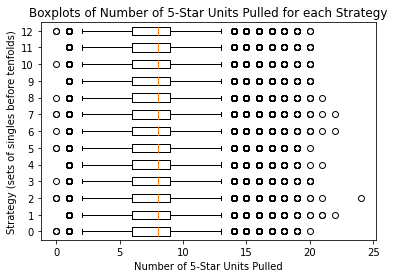

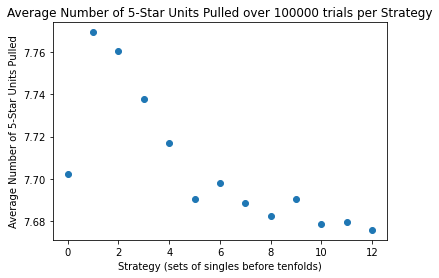

Strategy 0 resulted in an average of	7.70214	5-star units in 100000 trials.
Strategy 1 resulted in an average of	7.76949	5-star units in 100000 trials.
Strategy 2 resulted in an average of	7.76052	5-star units in 100000 trials.
Strategy 3 resulted in an average of	7.7378	5-star units in 100000 trials.
Strategy 4 resulted in an average of	7.71692	5-star units in 100000 trials.
Strategy 5 resulted in an average of	7.69018	5-star units in 100000 trials.
Strategy 6 resulted in an average of	7.69779	5-star units in 100000 trials.
Strategy 7 resulted in an average of	7.68847	5-star units in 100000 trials.
Strategy 8 resulted in an average of	7.68243	5-star units in 100000 trials.
Strategy 9 resulted in an average of	7.69015	5-star units in 100000 trials.
Strategy 10 resulted in an average of	7.6787	5-star units in 100000 trials.
Strategy 11 resulted in an average of	7.67944	5-star units in 100000 trials.
Strategy 12 resulted in an average of	7.67569	5-star units in 100000 trials.


The proba

In [5]:
import statistics
import matplotlib.pyplot as plt
from scipy import stats

# Gets averages for each strategy
averagePerStrategy = [statistics.mean(strategyTrials) for strategyTrials in results]

# Boxplots for each strategy
plt.figure()
plt.boxplot(results, labels=strategies, vert=False)
plt.title("Boxplots of Number of 5-Star Units Pulled for each Strategy")
plt.xlabel("Number of 5-Star Units Pulled")
plt.ylabel("Strategy (sets of singles before tenfolds)")
plt.show()

# Scatter plot of means
plt.figure()
plt.plot(strategies, averagePerStrategy, 'o')
plt.title("Average Number of 5-Star Units Pulled over {} trials per Strategy".format(numberTrials))
plt.xlabel("Strategy (sets of singles before tenfolds)")
plt.ylabel("Average Number of 5-Star Units Pulled".format(numberTrials))
plt.show()

# Print averages
for strategy, average in enumerate(averagePerStrategy):
    print("Strategy {} resulted in an average of\t{}\t5-star units in {} trials.".format(strategy, average, numberTrials))
print("\n")
    
# ANOVA of strategies
_, pValueOfANOVANull = stats.f_oneway(*results)
print("The probability that the strategies have the same mean number of 5-star units pulled is {:10.10f} (calculated with ANOVA).\n".format(pValueOfANOVANull))

# t-Tests between strategies 1, 2, and 3 because they are often close to each other
_, pValueOfTTestNull0 = stats.ttest_ind(results[1], results[2])
_, pValueOfTTestNull1 = stats.ttest_ind(results[2], results[3])
print("The probability that differences between strategy 1 and strategy 2 were caused by chance is {:10.10f} (calculated with t-Test).".format(pValueOfTTestNull0))
print("The probability that differences between strategy 2 and strategy 3 were caused by chance is {:10.10f} (calculated with t-Test).\n".format(pValueOfTTestNull1))

# Prints the best strategy
print("Strategy {} performed the best!".format(averagePerStrategy.index(max(averagePerStrategy))))

## Conclusion / Discussion
asdf